In [5]:
# import libraries
import os
import torch
from torch.utils.data import Dataset
from PIL import Image
import pandas as pd
from torchvision.transforms import transforms
import torchvision
import numpy as np
import json
import cv2
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
from sklearn.metrics import f1_score, confusion_matrix
from sklearn.metrics import precision_recall_fscore_support
from sklearn import preprocessing
from tqdm.notebook import tqdm

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
# class to load image
class PNGDataset(Dataset):
    def __init__(self, root_dir, df, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.filenames = os.listdir(root_dir)
        self.df = df

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        filename = self.filenames[idx]
        file_name = str(self.df['id'][idx])
        if len(file_name) == 4:
            file_name = '0'+file_name
        img_path = os.path.join(self.root_dir, file_name+'.png')
        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image, self.df['label'][idx]

In [8]:
# get train labels with images
train_labels = pd.read_json('/content/drive/MyDrive/DL/DL Assignments/A4/hateful_memes/train.jsonl', lines=True)
train_labels

,id,img,label,text
0,42953,img/42953.png,0,its their character not their color that matters
1,23058,img/23058.png,0,don't be afraid to love again everyone is not ...
2,13894,img/13894.png,0,putting bows on your pet
3,37408,img/37408.png,0,i love everything and everybody! except for sq...
4,82403,img/82403.png,0,"everybody loves chocolate chip cookies, even h..."
...,...,...,...,...
8495,10423,img/10423.png,1,nobody wants to hang auschwitz me
8496,98203,img/98203.png,1,when god grants you a child after 20 years of ...
8497,36947,img/36947.png,1,gays on social media: equality! body positivit...
8498,16492,img/16492.png,1,having a bad day? you could be a siamese twin ...


In [9]:
# get val labels with images
val_labels = pd.read_json(path_or_buf='/content/drive/MyDrive/DL/DL Assignments/A4/hateful_memes/dev_seen.jsonl', lines=True)
val_labels

,id,img,label,text
0,8291,img/08291.png,1,white people is this a shooting range
1,46971,img/46971.png,1,bravery at its finest
2,3745,img/03745.png,1,your order comes to $37.50 and your white priv...
3,83745,img/83745.png,1,it is time.. to send these parasites back to t...
4,80243,img/80243.png,1,mississippi wind chime
...,...,...,...,...
495,83675,img/83675.png,0,i'm gonna be like phelps one day
496,37198,img/37198.png,0,when you're so relaxed you can feel yourself g...
497,48670,img/48670.png,0,look at this sandwich maker club i found on wi...
498,9863,img/09863.png,0,diverse group of women


In [10]:
# get test labels with images
test_labels = pd.read_json(path_or_buf='/content/drive/MyDrive/DL/DL Assignments/A4/hateful_memes/test_seen.jsonl', lines=True)
test_labels

,id,img,label,text
0,16395,img/16395.png,1,handjobs sold seperately
1,37405,img/37405.png,1,introducing fidget spinner for women
2,94180,img/94180.png,1,happy pride month let's go beat up lesbians
3,54321,img/54321.png,1,laughs in [majority of u.s crime rate]
4,97015,img/97015.png,1,finds out those 72 virgins.. are goats
...,...,...,...,...
995,3869,img/03869.png,0,a mother's love for the child is a divine thing
996,23817,img/23817.png,0,sea monkeys
997,56280,img/56280.png,0,little miss muffet sat on her tuffet
998,29384,img/29384.png,0,they're in a row


In [11]:
# apply necessary transformations like resize and normalize
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((256,256)),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])
# split into train, test and val set
train_dataset = PNGDataset('/content/drive/MyDrive/DL/DL Assignments/A4/hateful_memes/img', train_labels)
val_dataset = PNGDataset('/content/drive/MyDrive/DL/DL Assignments/A4/hateful_memes/img', val_labels)
test_dataset = PNGDataset('/content/drive/MyDrive/DL/DL Assignments/A4/hateful_memes/img', test_labels)

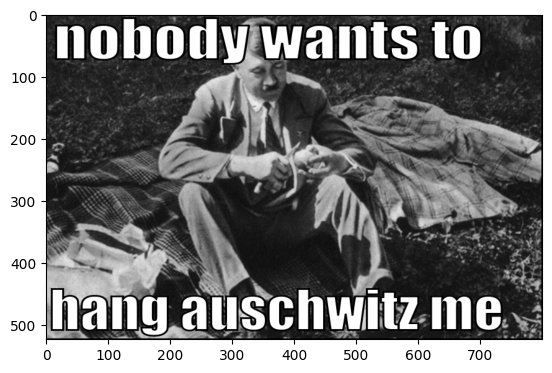

In [12]:
plt.imshow(train_dataset[8495][0])

In [13]:
train_dataset[8495][1]

1

In [14]:
# class that applies transformations to images
class ImageDataset():
    def __init__(self, data,transform=None, target_transform=None):
        self.data=data
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        image = self.data[idx][0]
        label = self.data[idx][1]
        if self.transform is not None:
            image = self.transform(image)
        return image, label

In [15]:
batch_size = 256
# defining data loaders
train_loader = torch.utils.data.DataLoader(ImageDataset(train_dataset,transform=transform), batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(ImageDataset(val_dataset,transform=transform), batch_size)
test_loader = torch.utils.data.DataLoader(ImageDataset(test_dataset,transform=transform), batch_size*2)

In [16]:
def get_default_device():
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

# data loader class
class DeviceDataLoader():
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        return len(self.dl)


In [20]:
# using pre trained resnet model
resnet18 = torchvision.models.resnet18(pretrained=True)
resnet18

/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 128MB/s]


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [21]:
# change fully conneced layer to 2 nodes
resnet18.fc = nn.Linear(in_features=512, out_features=2)

In [ ]:
# defining loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(resnet18.parameters(), lr=0.0001)

In [ ]:
device = get_default_device()
device

device(type='cuda')

In [ ]:
# load data using data loaders
train_loader = DeviceDataLoader(train_loader, device)
val_loader = DeviceDataLoader(val_loader, device)
test_loader=DeviceDataLoader(test_loader,device)
to_device(resnet18, device);
# resnet18=resnet18.to('device')

In [ ]:
# function to compute results on validation set
def validation(model, validateloader, criterion):
    
    val_loss = 0
    accuracy = 0
    correct = 0
    total = 0
    count=0

    for images, labels in iter(validateloader):
        outputs = model(images)
        val_loss += criterion(outputs, labels).item()
        count+=1
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    accuracy = 100 * correct / total
    
    return val_loss, accuracy, count

In [ ]:
# func to compute accuracy
def acc(ouputs,labels):
    total=0
    accuracy = 0
    correct=0
    _, predicted = torch.max(outputs.data, 1)
    total += labels.size(0)
    correct += (predicted == labels).sum().item()
    accuracy = 100 * correct / total
    
    return accuracy

In [ ]:
total_loss_train = []
total_loss_validation = []
taccuracy = []
vaccuracy = []
# train loop
for epoch in range(10):

    print(epoch + 1)
    batch_loss_train=0
    num_batches = 0
    running_loss = 0.0
    temp_acc = 0
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data
        optimizer.zero_grad()
        
        outputs = resnet18(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        temp_acc+=acc(outputs,labels)
        batch_loss_train+=loss.item()
        running_loss = loss.item()
        num_batches+=1
      
    taccuracy.append(temp_acc/num_batches)    
    batch_loss_train/=num_batches
    print("Training Loss ",batch_loss_train)

    total_loss_train.append(batch_loss_train)
    with torch.no_grad():
      validation_loss, accuracy,cnt = validation(resnet18, val_loader, criterion)
      vaccuracy.append(accuracy)
      total_loss_validation += [validation_loss/cnt]
      print("Validation loss is ",validation_loss/cnt)
      print("Validation Acc is ", accuracy)
    

print('Finished Training')

1


/usr/local/lib/python3.9/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Training Loss  0.7012137384975657
Validation loss is  0.8427209854125977
Validation Acc is  52.6
2
Training Loss  0.47674525660627026
Validation loss is  0.8306697010993958
Validation Acc is  52.2
3
Training Loss  0.31880567967891693
Validation loss is  1.0074455440044403
Validation Acc is  52.2
4
Training Loss  0.1646270416676998
Validation loss is  1.1753060221672058
Validation Acc is  54.4
5
Training Loss  0.07764309392694164
Validation loss is  1.4705453515052795
Validation Acc is  50.0
6
Training Loss  0.04087790983783848
Validation loss is  1.6386955380439758
Validation Acc is  51.6
7
Training Loss  0.025751551229725864
Validation loss is  1.7685757875442505
Validation Acc is  52.4
8
Training Loss  0.017585627720965183
Validation loss is  1.9033766984939575
Validation Acc is  50.4
9
Training Loss  0.01664851141600486
Validation loss is  1.9791285395622253
Validation Acc is  51.2
10
Training Loss  0.010387925574939479
Validation loss is  2.0587543845176697
Validation Acc is  50.6


In [ ]:
# save the model
torch.save(resnet18.state_dict(),"model.pth")

In [ ]:
taccuracy

[58.22875424208145,
 76.9389847285068,
 87.40366940045249,
 95.00494909502262,
 98.23246606334841,
 99.18605062217195,
 99.55281391402714,
 99.75961538461537,
 99.74724264705883,
 99.8736213235294]

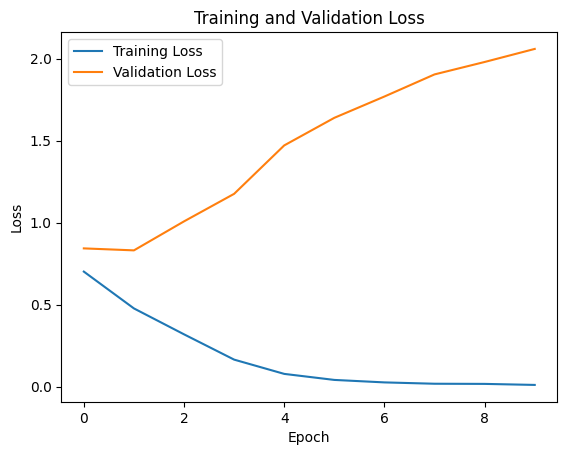

In [ ]:
# Plot the training and validation loss
plt.plot(total_loss_train, label='Training Loss')
plt.plot(total_loss_validation, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

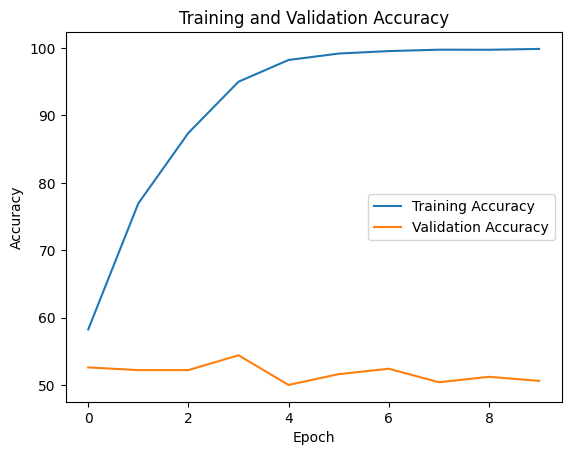

In [ ]:
# Plot the training and validation loss
plt.plot(taccuracy, label='Training Accuracy')
plt.plot(vaccuracy, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

In [ ]:
state_dict = torch.load("model.pth")
resnet18.load_state_dict(state_dict)

<All keys matched successfully>

In [ ]:
# measure test accurancy
correct = 0
total = 0
with torch.no_grad():
    for data in test_loader:
        images, labels = data
        outputs = resnet18(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Test Accuracy :- {100 * correct // total} %')

Test Accuracy :- 54 %


In [ ]:
# Initialize lists to store labels and predictions
labels = []
predictions = []

# Iterate over test set and make predictions
with torch.no_grad():
    for images, targets in test_loader:
        outputs = resnet18(images)
        _, preds = torch.max(outputs, 1)
        labels += targets.tolist()
        predictions += preds.tolist()

# Calculate overall precision, recall, and F1 score
precision, recall, f1_score, _ = precision_recall_fscore_support(labels, predictions, average='macro')

print(f'Overall Precision: {precision:.4f}')
print(f'Overall Recall: {recall:.4f}')
print(f'Overall F1 Score: {f1_score:.4f}')

# Calculate class-wise precision, recall, and F1 score
precision, recall, f1_score, support = precision_recall_fscore_support(labels, predictions)

for i in range(2):
    print(f'Class {i} - Precision: {precision[i]:.4f}, Recall: {recall[i]:.4f}, F1 Score: {f1_score[i]:.4f}')


Overall Precision: 0.5422
Overall Recall: 0.5363
Overall F1 Score: 0.5212
Class 0 - Precision: 0.5363, Recall: 0.7235, F1 Score: 0.6160
Class 1 - Precision: 0.5481, Recall: 0.3490, F1 Score: 0.4264


In [1]:
import pickle
with open('parrot.pkl', 'rb') as f:
  compare_labels = pickle.load(f)

In [24]:
state_dict = torch.load("/content/drive/MyDrive/DL/DL Assignments/A4/Q1/model.pth",map_location=torch.device('cpu'))
resnet18.load_state_dict(state_dict)

<All keys matched successfully>

In [18]:
# get test labels with images
# test_labels = pd.read_json(path_or_buf='/content/drive/MyDrive/hateful_memes/test_seen.jsonl', lines=True)
# l1 = list(test_labels[test_labels.label == 1][:50].index.values)
# l2 = list(test_labels[test_labels.label == 0][:50].index.values)

import pickle
with open('parrot.pkl', 'rb') as f:
  compare_labels = pickle.load(f)
# apply necessary transformations like resize and normalize
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((256,256)),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])
# split into train, test and val se
compare_dataset = PNGDataset('/content/drive/MyDrive/DL/DL Assignments/A4/hateful_memes/img', compare_labels)

# defining data loaders
compare_loader = torch.utils.data.DataLoader(ImageDataset(compare_dataset,transform=transform), 100)

In [26]:
get_graph_node_names(resnet18)

(['x',
  'conv1',
  'bn1',
  'relu',
  'maxpool',
  'layer1.0.conv1',
  'layer1.0.bn1',
  'layer1.0.relu',
  'layer1.0.conv2',
  'layer1.0.bn2',
  'layer1.0.add',
  'layer1.0.relu_1',
  'layer1.1.conv1',
  'layer1.1.bn1',
  'layer1.1.relu',
  'layer1.1.conv2',
  'layer1.1.bn2',
  'layer1.1.add',
  'layer1.1.relu_1',
  'layer2.0.conv1',
  'layer2.0.bn1',
  'layer2.0.relu',
  'layer2.0.conv2',
  'layer2.0.bn2',
  'layer2.0.downsample.0',
  'layer2.0.downsample.1',
  'layer2.0.add',
  'layer2.0.relu_1',
  'layer2.1.conv1',
  'layer2.1.bn1',
  'layer2.1.relu',
  'layer2.1.conv2',
  'layer2.1.bn2',
  'layer2.1.add',
  'layer2.1.relu_1',
  'layer3.0.conv1',
  'layer3.0.bn1',
  'layer3.0.relu',
  'layer3.0.conv2',
  'layer3.0.bn2',
  'layer3.0.downsample.0',
  'layer3.0.downsample.1',
  'layer3.0.add',
  'layer3.0.relu_1',
  'layer3.1.conv1',
  'layer3.1.bn1',
  'layer3.1.relu',
  'layer3.1.conv2',
  'layer3.1.bn2',
  'layer3.1.add',
  'layer3.1.relu_1',
  'layer4.0.conv1',
  'layer4.0.bn1',


/usr/local/lib/python3.9/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


100 100 100


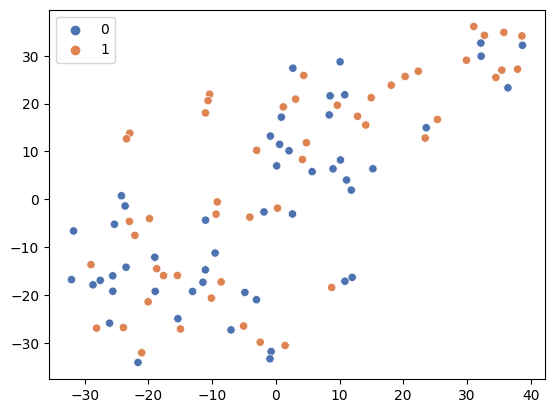

In [27]:
from torchvision.models.feature_extraction import create_feature_extractor
from torchvision.models.feature_extraction import get_graph_node_names
import seaborn as sns
from matplotlib.colors import ListedColormap
from sklearn.manifold import TSNE

# train_loader = 
count=0
with torch.no_grad() :
    for i,j in compare_loader:
      X = (create_feature_extractor(resnet18.to('cpu'),{"avgpool":'avgpool'})(i.to('cpu'))['avgpool']).detach().numpy()
      X = X.reshape(100,-1)
      X_embedded = TSNE(n_components=2, learning_rate='auto',init='pca', perplexity=3).fit_transform(X)
      x1= []
      y1 = []
      for i in X_embedded:
        x1.append(i[0])
        y1.append(i[1])
      print(len(j),len(x1),len(y1))
      sns.scatterplot(x=x1,y=y1,hue=j,palette="deep")
      
cmap = ListedColormap(sns.color_palette("deep", 256).as_hex())